## 2 COUPLED reactions of different speeds:  
### A <-> B (fast) and B <-> C (slow)
All 1st order. Taken to equilibrium.   
The concentration of the intermediate product B manifests 1 oscillation ("overshoot")

LAST REVISED: Jan. 4, 2023

In [1]:
# Extend the sys.path variable, to contain the project's root directory
import set_path
set_path.add_ancestor_dir_to_syspath(2)  # The number of levels to go up 
                                         # to reach the project's home, from the folder containing this notebook

Added 'D:\Docs\- MY CODE\BioSimulations\life123-Win7' to sys.path


In [2]:
from experiments.get_notebook_info import get_notebook_basename

from modules.reactions.reaction_data import ReactionData as chem
from modules.reactions.reaction_dynamics import ReactionDynamics

import numpy as np
import plotly.express as px
from modules.visualization.graphic_log import GraphicLog

In [3]:
# Initialize the HTML logging (for the graphics)
log_file = get_notebook_basename() + ".log.htm"    # Use the notebook base filename for the log file

# Set up the use of some specified graphic (Vue) components
GraphicLog.config(filename=log_file,
                  components=["vue_cytoscape_1"],
                  extra_js="https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.21.2/cytoscape.umd.js")

-> Output will be LOGGED into the file 'react_5.log.htm'


# Initialize the System
Specify the chemicals and the reactions

In [4]:
# Specify the chemicals
chem_data = chem(names=["A", "B", "C"])

# Reaction A <-> B (fast)
chem_data.add_reaction(reactants=["A"], products=["B"],
                       forward_rate=32., reverse_rate=8.) 

# Reaction B <-> C (slow)
chem_data.add_reaction(reactants=["B"], products=["C"],
                       forward_rate=3., reverse_rate=2.) 

print("Number of reactions: ", chem_data.number_of_reactions())

Number of reactions:  2


In [5]:
chem_data.describe_reactions()

Number of reactions: 2 (at temp. 25 C)
0: A <-> B  (kF = 32 / kR = 8 / Delta_G = -3,436.56 / K = 4) | 1st order in all reactants & products
1: B <-> C  (kF = 3 / kR = 2 / Delta_G = -1,005.13 / K = 1.5) | 1st order in all reactants & products


In [6]:
# Send a plot of the network of reactions to the HTML log file
graph_data = chem_data.prepare_graph_network()
GraphicLog.export_plot(graph_data, "vue_cytoscape_1")

[GRAPHIC ELEMENT SENT TO LOG FILE `react_5.log.htm`]


# Start the simulation

In [7]:
dynamics = ReactionDynamics(reaction_data=chem_data)

### Set the initial concentrations of all the chemicals, in their index order

In [8]:
dynamics.set_conc([60., 0, 10.], snapshot=True)

In [9]:
dynamics.describe_state()

SYSTEM STATE at Time t = 0:
3 species:
  Species 0 (A). Conc: 60.0
  Species 1 (B). Conc: 0.0
  Species 2 (C). Conc: 10.0


In [10]:
dynamics.history.get()

,SYSTEM TIME,A,B,C,caption
0,0.0,60.0,0.0,10.0,Initial state


## Run the reaction

In [11]:
dynamics.set_diagnostics()       # To save diagnostic information about the call to single_compartment_react()
#dynamics.verbose_list = [1, 2, 3]      # Uncomment for detailed run information (meant for debugging the adaptive variable time step)

# The changes of concentrations vary very rapidly early on; so, we'll be using dynamic_step=4 , i.e. increase time resolution
# by x4 initially, as long as the reaction remains "fast" (based on a threshold of 5% change)
dynamics.single_compartment_react(time_step=0.05, reaction_duration=1.0,
                                  snapshots={"initial_caption": "1st reaction step",
                                             "final_caption": "last reaction step"},
                                  dynamic_step=20)      
                                  # Accepting the default:  fast_threshold=5

### Note: the argument _dynamic_step=4_ splits the time steps in 4 whenever the reaction is "fast" (as determined using fast_threshold=5)

In [12]:
df = dynamics.history.get()
df

,SYSTEM TIME,A,B,C,caption
0,0.0000,60.000000,0.000000,10.000000,Initial state
1,0.0025,55.200000,4.850000,9.950000,"Interm. step, due to the fast rxns: [0, 1]"
2,0.0050,50.881000,9.182375,9.936625,"Interm. step, due to the fast rxns: [0, 1]"
3,0.0075,46.994168,13.050023,9.955810,"Interm. step, due to the fast rxns: [0, 1]"
4,0.0100,43.495635,16.500460,10.003906,"Interm. step, due to the fast rxns: [0, 1]"
...,...,...,...,...,...
149,0.8000,6.538521,26.059573,37.401906,
150,0.8500,6.500717,25.928632,37.570652,
151,0.9000,6.471022,25.826096,37.702881,
152,0.9500,6.447825,25.745667,37.806508,


### Notice how the reaction proceeds in smaller steps in the early times, when the concentrations are changing much more rapidly

In [13]:
# Let's look at two early arrays of concentrations, from the run's history
arr0 = dynamics.get_historical_concentrations(4)
arr1 = dynamics.get_historical_concentrations(5)
arr0, arr1

(array([43.49563455625, 16.50045963359375, 10.00390581015625], dtype=object),
 array([40.345992984421876, 19.5763672872207, 10.077639728357422],
       dtype=object))

In [14]:
# Let's verify that the stoichiometry is being respected        # TODO: THIS MUST GET GENERALIZED for multiple reactions!!! *****
dynamics.stoichiometry_checker(rxn_index=0, 
                               conc_arr_before = arr0, 
                               conc_arr_after = arr1)

False

In [15]:
dynamics.stoichiometry_checker(rxn_index=1, 
                               conc_arr_before = arr0, 
                               conc_arr_after = arr1)

False

In [16]:
dynamics.diagnostic_data.get().loc[0]    # Conveniently seen in the diagnostic data

TIME                               0.0
Delta A                           -4.8
Delta B                            4.8
Delta C                            0.0
reaction                             0
substep                              0
time_subdivision                    20
caption             delta_time: 0.0025
Name: 0, dtype: object

## Note: "A" (now largely depleted) is the limiting reagent

### Check the final equilibrium

In [17]:
dynamics.get_system_conc()

array([ 6.42957196, 25.68272114, 37.8877069 ])

In [18]:
# Verify that all the reactions have reached equilibrium
dynamics.is_in_equilibrium(rxn_index=0, conc=dynamics.get_conc_dict())       # TODO: generalize to multiple reactions

Ratio of forward/reverse reaction rates: 4.0
Ratio of reactant/product concentrations, adjusted for reaction orders: 3.99447
    [B] / [A]


True

In [19]:
dynamics.is_in_equilibrium(rxn_index=1, conc=dynamics.get_conc_dict())

Ratio of forward/reverse reaction rates: 1.5
Ratio of reactant/product concentrations, adjusted for reaction orders: 1.47522
    [C] / [B]


True

## Plots of changes of concentration with time

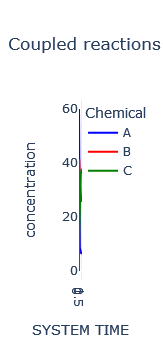

In [22]:
fig = px.line(data_frame=dynamics.get_history(), x="SYSTEM TIME", y=["A", "B", "C"], 
              title="Coupled reactions A <-> B and B <-> C",
              color_discrete_sequence = ['blue', 'red', 'green'],
              labels={"value":"concentration", "variable":"Chemical"})
fig.show()

#### For diagnostic insight, uncomment the following lines:

In [21]:
#dynamics.examine_run(df=df, time_step=0.01)  
# the time step MUST match the value used in call to single_compartment_react()

#dynamics.diagnose_variable_time_steps()

#dynamics.diagnostic_data.get()

#dynamics.diagnostic_data_baselines.get()